### Suggested object structure for multichannel data

#### package structure
- src 
    - core
        - data structure containing object-level information
        - Datastream (object): a collection of Channels with aligned samples
            - Channel (object): Data stream, with attributes
                - channel can have multiple subtypes: 
                    - EXGChannel(parent = Channel): channel (1 or more dimensions) of EEG or EMG or ECG data
                    - AccelerometerChannel(parent = Channel): Channel of movement/accelerometer data
                    - DerivedChannel(parent = Channel): 1 or more channels of derived data (e.g. instantaneous heartrate, spectral features, pitch, roll, heading, etc)
    - preprocessing 
        - bandpass filter
        - noise reduction / signal correction  
            - e.g. remove outliers
            - PCA whitening
    - feature extraction
        - compute heartrate
        - compute HRV
        - compute spectral features
        - calculate stroke rate
        - compute pitch, roll heading
        - etc
    - unsupervised methods
        - dimensionality reduction (e.g. PCA, UMAP)
    - classification
        - sklearn models 
- notebooks
- figs
- etc...

### Channels
* 'ECG_Raw_Ch1': Electrocardiogram (voltage, this is noisy)
'ECG_ICA2': artifact removal of EEG (don't use)
'LEOG_Pruned_Ch2': EOG = electro-oculargram (L = left) - pruned = removing ECG artifacts
'LEMG_Pruned_Ch4': EMG = (don't use)
'REEG2_Pruned_Ch7': what is this? (don't use)
'LEEG3_Pruned_Ch8': what is this? (don't use)
'REEG2_Raw_Ch7': what is this? (don't use)
'LEEG3_Raw_Ch8': what is this? (don't use)
* 'EEG_ICA5': EEG with artifact removal (is this used averaged R and L?)
* 'pitch': 
* 'roll':
* 'heading': direction the animal is facing 
'GyrZ': 
'MagZ': Direction with respect to earth magnetic field (what is the unit)
'ODBA': Overall Dynamic Body Acceleration - this is derived from the body movement
'Pressure': Water pressure (depth in meters)

In [1]:
import yasa
import mne
import os
import sys
import scipy
import glob
import six
import wfdb
import pytz
import sklearn
import pomegranate
import pyedflib
import sleepecg
import datetime
import wfdb.processing
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import entropy as ent
import seaborn as sns
from matplotlib import mlab as mlab
from sleepecg import detect_heartbeats
import matplotlib.gridspec as gs


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Add the src directory to the path
current_path = os.getcwd()
src_path = os.path.abspath(os.path.join(current_path, '..', 'src'))
sys.path.insert(0, src_path) 
from feature_extraction import *

<a id='data_loading'></a>

---
# Load in data

---

### Navigate to data folder

In [4]:
# Construct the relative path to the folder containing processed data
data_folder_path = os.path.abspath(os.path.join("..", "data"))
process_data_path = os.path.abspath(os.path.join("..", "data", "01_processed-data"))
print(process_data_path)
# Get the current working directory
current_path = os.getcwd()

# Check if the current directory ends with the "Data" folder
# if not current_path.endswith("01_processed-data"):
#     # Change the current working directory to the "Data" folder, if not already there
#     os.chdir(process_data_path)
#     print(f"Changed directory to: {os.getcwd()}")
# else:
#     print("Already in the correct data directory.")

# Print the current working directory
print("Current Working Directory:", os.getcwd())

/Users/tsainbur/Documents/github/Seal-Sleep-Classifier/data/01_processed-data
Current Working Directory: /Users/tsainbur/Documents/github/Seal-Sleep-Classifier/notebooks


### Read in header information

In [5]:
# Read the header information to identify channels and their sampling frequencies
info = mne.io.read_raw_edf(f'{process_data_path}/test12_Wednesday_05_ALL_PROCESSED.edf',
                           preload=False).info

# Print the channel information
print(info)

# Identify channels and their corresponding sampling frequencies
channels_info = info['chs']
sampling_freq_map = {}

Extracting EDF parameters from /Users/tsainbur/Documents/github/Seal-Sleep-Classifier/data/01_processed-data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 08:21:02 UTC
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>


#### Load in raw data for just day one of the data

In [6]:
# Load the EDF file, excluding the EOGs and EKG channels
raw = mne.io.read_raw_edf(f'{process_data_path}/test12_Wednesday_05_DAY1_PROCESSED.edf', preload=True)
# raw.resample(100)                      # Downsample the data to 100 Hz
# raw.filter(0.1, 40)                    # Apply a bandpass filter from 0.1 to 40 Hz
# raw.pick_channels(['C4-A1', 'C3-A2'])  # Select a subset of EEG channels
raw # Outputs summary data about file

# Inspect Data
print(raw.info)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

# Rename channels (replace spaces if any)
channel_renaming_dict = {name: name.replace(' ', '_') for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict)
print('The channels are:', raw.ch_names)

# ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 
# 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure']

# Assuming 'raw' is your Raw object from MNE
channel_types = {}

for ch in raw.ch_names:
    if ch.startswith('ECG'):
        channel_types[ch] = 'ecg'
    elif ch.startswith(('LEOG', 'REOG')):
        channel_types[ch] = 'eog'
    elif ch.startswith(('LEMG', 'REMG')):
        channel_types[ch] = 'emg'
    elif ch.startswith(('LEEG', 'REEG')):
        channel_types[ch] = 'eeg'
    elif ch in ['pitch', 'roll', 'heading']:
        channel_types[ch] = 'resp'
    elif ch in ['GyrZ', 'MagZ', 'ODBA']:
        channel_types[ch] = 'syst'
    elif ch in ['Pressure']:
        channel_types[ch] = 'misc'
    elif ch == 'Heart_Rate':
        channel_types[ch] = 'bio'

# Now set the channel types
raw.set_channel_types(channel_types)
print()

Extracting EDF parameters from /Users/tsainbur/Documents/github/Seal-Sleep-Classifier/data/01_processed-data/test12_Wednesday_05_DAY1_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Reading 0 ... 43199999  =      0.000 ... 86399.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 18 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 14:45:22 UTC
 nchan: 18
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure', 'MagX', 'MagY']
The sampling frequency is: 500.0
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure', 'MagX', 'MagY']



/var/folders/pk/frdp2vg11gz5mr8c2vky1qnw0000gp/T/ipykernel_12199/2530690281.py:43: RuntimeWarning: The unit for channel(s) GyrZ, MagZ, ODBA, Pressure has changed from V to NA.
  raw.set_channel_types(channel_types)


#### Read labeled data

In [237]:
labeled_data_path = os.path.abspath(os.path.join("..", "data", "02_annotated-data"))
print(process_data_path)

# Load labeled data
# Path to CSV with scored data
file_path = f'{labeled_data_path}/test12_Wednesday_06_Hypnogram_JKB_1Hz.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['R.Time'] = pd.to_datetime(df['R.Time']).dt.tz_localize('America/Los_Angeles')
df['Sleep.Code'].value_counts(normalize=True)

print('The start time for labels in PST (Los Angeles) is:', df['R.Time'].min())
print('The end time for labels in PST (Los Angeles) is:', df['R.Time'].max())


/Users/tsainbur/Documents/github/Seal-Sleep-Classifier/data/01_processed-data
The start time for labels in PST (Los Angeles) is: 2019-10-25 14:45:22-07:00
The end time for labels in PST (Los Angeles) is: 2019-10-29 00:36:53-07:00


In [241]:
df['R.Time'].values

array(['2019-10-25T21:45:22.000000000', '2019-10-25T21:45:23.000000000',
       '2019-10-25T21:45:24.000000000', ...,
       '2019-10-29T07:36:51.000000000', '2019-10-29T07:36:52.000000000',
       '2019-10-29T07:36:53.000000000'], dtype='datetime64[ns]')

### Describe data

In [7]:
# Inspect Data
print(raw.info)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

# Extract the measurement date (start time) from raw.info
start_time = raw.info['meas_date']
fs = raw.info['sfreq']

# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')

# Convert to datetime object in PST
if isinstance(start_time, datetime.datetime):
    # If it's already a datetime object, just replace the timezone
    recording_start_datetime = start_time.replace(tzinfo=None).astimezone(pst_timezone)
elif isinstance(start_time, (int, float)):
    # Convert timestamp to datetime in PST
    recording_start_datetime = pst_timezone.localize(datetime.datetime.fromtimestamp(start_time))
else:
    # Handle other formats if necessary
    pass

# Calculate the recording duration in seconds
recording_duration_seconds = len(raw) / fs

# Calculate the recording end datetime
recording_end_datetime = recording_start_datetime + datetime.timedelta(seconds=recording_duration_seconds)

# Calculate duration as a timedelta object
duration_timedelta = datetime.timedelta(seconds=recording_duration_seconds)

# Create a time index
#time_index = pd.date_range(recoring_start_datetime, recording_end_datetime)

# Format duration into days, hours, minutes, and seconds
days = duration_timedelta.days
hours, remainder = divmod(duration_timedelta.seconds, 3600)
minutes, seconds = divmod(remainder, 60)

print('The start time in PST (Los Angeles) is:', recording_start_datetime)
print('The end time in PST (Los Angeles) is:', recording_end_datetime)
print(f'Duration: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds')


<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 2 ECG, 1 EOG, 1 EMG, 7 EEG, 3 RESP, 3 SYST, 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 14:45:22 UTC
 nchan: 18
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure', 'MagX', 'MagY']
The sampling frequency is: 500.0
The start time in PST (Los Angeles) is: 2019-10-25 11:45:22-07:00
The end time in PST (Los Angeles) is: 2019-10-26 11:45:22-07:00
Duration: 1 days, 0 hours, 0 minutes, 0 seconds


#### Get metadata from file

Get start time, channel names, etc.

### Select Channels
* 'ECG_Raw_Ch1': Electrocardiogram (voltage, this is noisy)
'ECG_ICA2': artifact removal of EEG (don't use)
'LEOG_Pruned_Ch2': EOG = electro-oculargram (L = left) - pruned = removing ECG artifacts
'LEMG_Pruned_Ch4': EMG = (don't use)
'REEG2_Pruned_Ch7': what is this? (don't use)
'LEEG3_Pruned_Ch8': what is this? (don't use)
'REEG2_Raw_Ch7': what is this? (don't use)
'LEEG3_Raw_Ch8': what is this? (don't use)
* 'EEG_ICA5': EEG with artifact removal (is this used averaged R and L?)
* 'pitch': 
* 'roll': (radians)
* 'heading': direction the animal is facing (radians)
'GyrZ': 
'MagZ': Direction with respect to earth magnetic field (what is the unit)
'ODBA': Overall Dynamic Body Acceleration - this is derived from the body movement (pitch, roll, heading)
'Pressure': Water pressure (depth in meters)

In [8]:
channels = ['ECG_Raw_Ch1', 
            'EEG_ICA5', 
            'pitch', 
            'roll',
            'heading', 
            'ODBA', 
            'Pressure'
            ]

### View data

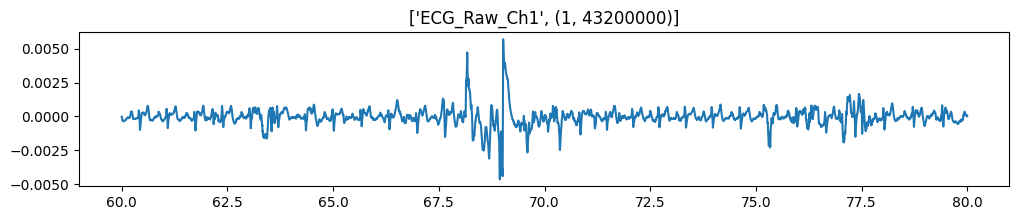

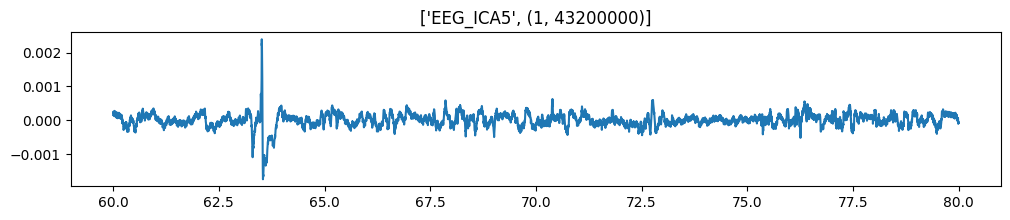

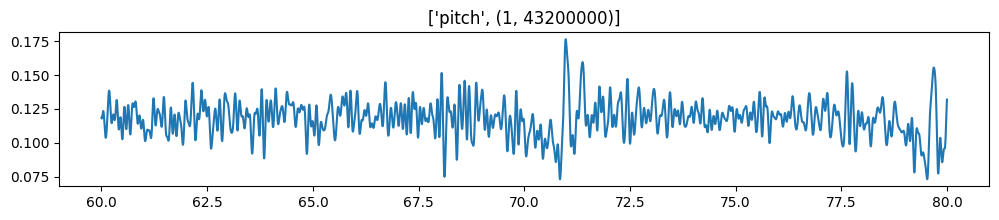

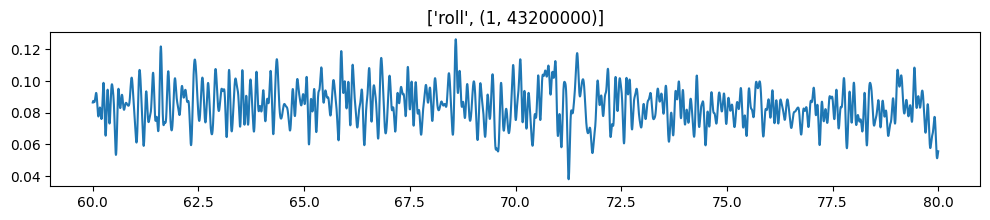

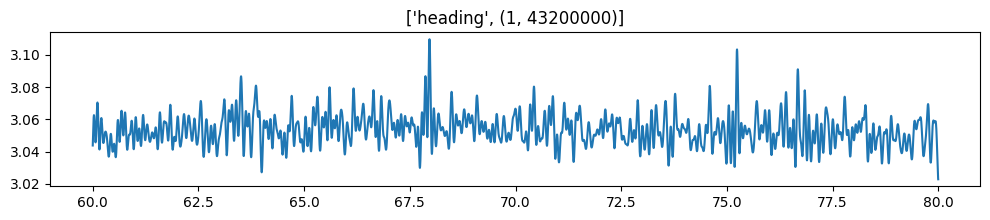

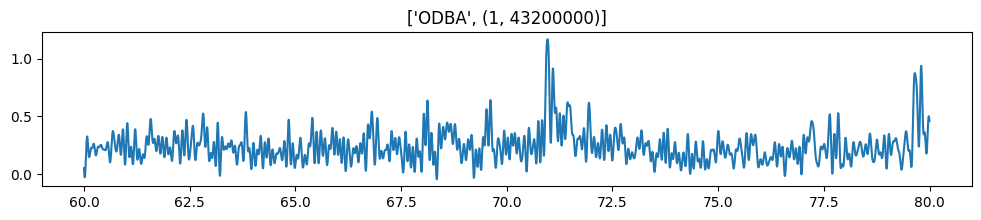

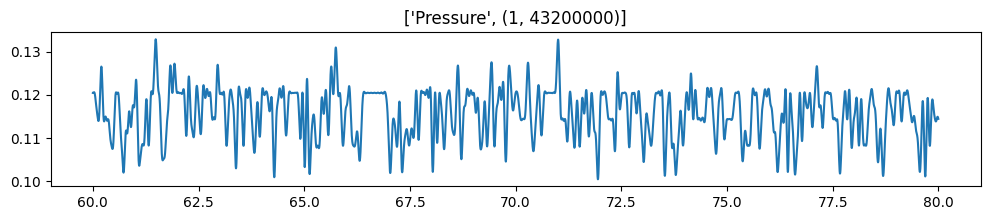

In [9]:
start_idx = 30000
stop_idx  = 40000
subsample = 1
for channel in channels:
    samples, timepoints = raw[channel]
    samples = samples[:, ::subsample]
    timepoints = timepoints[::subsample]
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_title([channel, samples.shape])
    ax.plot(timepoints[start_idx:stop_idx], samples[0, start_idx:stop_idx])
    plt.show()

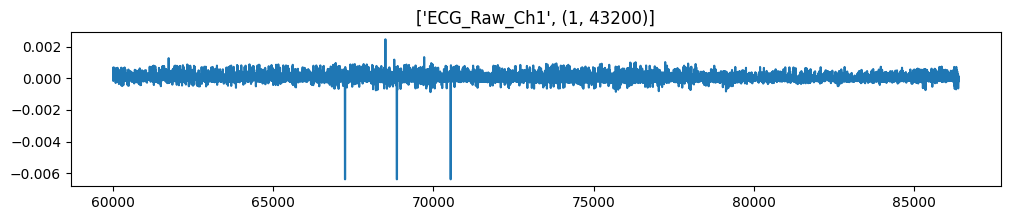

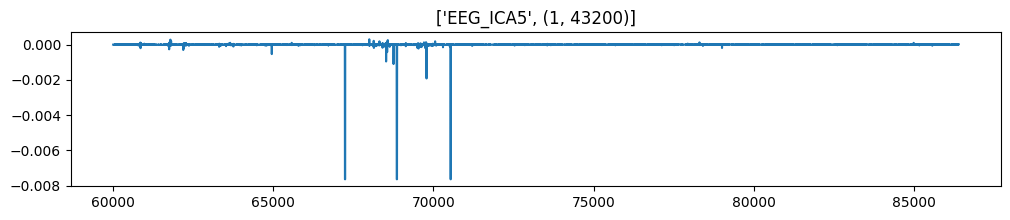

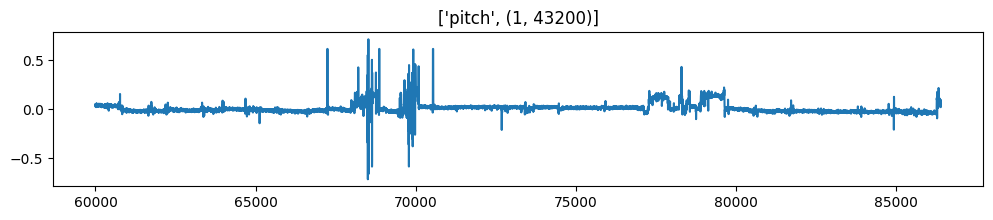

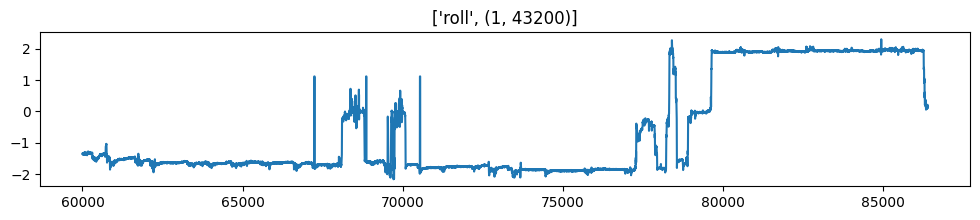

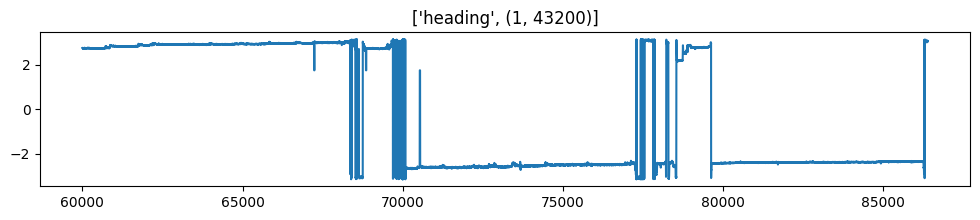

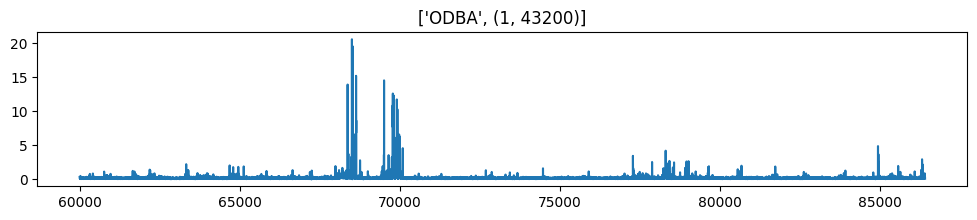

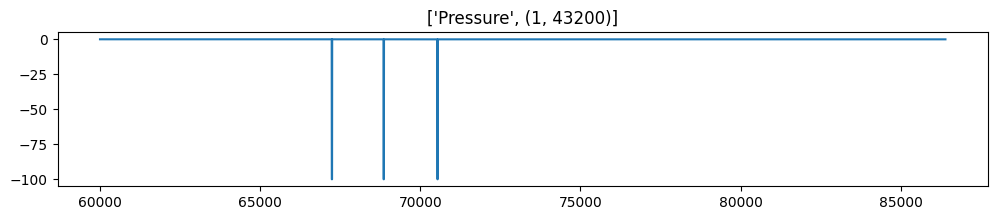

In [10]:
start_idx = 30000
stop_idx  = 400000
subsample = 1000
for channel in channels:
    samples, timepoints = raw[channel]
    samples = samples[:, ::subsample]
    timepoints = timepoints[::subsample]
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_title([channel, samples.shape])
    ax.plot(timepoints[start_idx:stop_idx], samples[0, start_idx:stop_idx])
    plt.show()

### Feature extraction

#### Heartrate

In [459]:
fs = raw.info['sfreq']  # Sampling frequency
fs

500.0

In [460]:
ECG_channel = "ECG_Raw_Ch1"
ecg_data, ecg_timepoint = raw[ECG_channel]
ecg_data.shape, ecg_timepoint.shape, fs

((1, 43200000), (43200000,), 500.0)

In [461]:
### subsample
start_idx = 8000000
stop_idx  = 22000000
ecg_data = ecg_data[0, start_idx:stop_idx]
ecg_timepoint = ecg_timepoint[start_idx:stop_idx]
ecg_data.shape, ecg_timepoint.shape, ecg_timepoint[-1] - ecg_timepoint[0]

((14000000,), (14000000,), 27999.998)

In [466]:
(ecg_timepoint[-1] - ecg_timepoint[0] ) / 60 / 60

7.777777222222222

In [462]:
recording_start_datetime

datetime.datetime(2019, 10, 25, 11, 45, 22, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>)

In [463]:
sample_times = [recording_start_datetime + datetime.timedelta(seconds=i) for i in ecg_timepoint]

In [464]:
sample_times_series = pd.Series(sample_times)

In [467]:
sample_times_series.name = 'R.Time'

In [468]:
np.datetime64(sample_times[0])

/var/folders/pk/frdp2vg11gz5mr8c2vky1qnw0000gp/T/ipykernel_12199/4155591771.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  np.datetime64(sample_times[0])


numpy.datetime64('2019-10-25T23:12:02.000000')

In [469]:
pd.Timestamp(sample_times[-1])

Timestamp('2019-10-25 23:58:41.998000-0700', tz='America/Los_Angeles')

In [470]:
timestamps = np.array([pd.Timestamp(i) for i in df['R.Time']])

In [471]:
timestamp_mask = (timestamps  < pd.Timestamp(sample_times[-1])) & (timestamps  > pd.Timestamp(sample_times[0]))

In [472]:
pd.Timestamp(sample_times[0]) , pd.Timestamp(sample_times[-1]) 

(Timestamp('2019-10-25 16:12:02-0700', tz='America/Los_Angeles'),
 Timestamp('2019-10-25 23:58:41.998000-0700', tz='America/Los_Angeles'))

In [473]:
timestamps[0], timestamps[-1]

(Timestamp('2019-10-25 14:45:22-0700', tz='America/Los_Angeles'),
 Timestamp('2019-10-29 00:36:53-0700', tz='America/Los_Angeles'))

In [474]:
timestamps > pd.Timestamp(sample_times[0]) 

array([False, False, False, ...,  True,  True,  True])

In [475]:
m = (timestamps > pd.Timestamp(sample_times[0])) & ((timestamps < pd.Timestamp(sample_times[-1])))

In [476]:
np.sum(m)

27999

In [477]:
df["Sleep.Code"].value_counts()

Sleep.Code
Active Waking         134431
Quiet Waking           42206
HV Slow Wave Sleep     36708
Drowsiness             22332
Certain REM Sleep      21285
LV Slow Wave Sleep     21217
Putative REM Sleep     10059
Unscorable              6454
Name: count, dtype: int64

In [478]:

merged_df = pd.merge_asof(sample_times_series.sort_values(), df.sort_values('R.Time'), left_on=sample_times_series.name, right_on='R.Time', direction='nearest')

# Get the 'Simple.Sleep.Code' column from the merged DataFrame
sleep_codes = merged_df['Simple.Sleep.Code'].tolist()

In [479]:
np.unique(sleep_codes, return_counts=True)

(array(['Active Waking', 'Drowsiness', 'Quiet Waking', 'REM', 'SWS'],
       dtype='<U13'),
 array([3563500,  478500, 2489251, 2098000, 5370749]))

In [480]:
#sleep_codes = [df.iloc[np.argmin(i - df['R.Time'])]['Simple.Sleep.Code'] for i in tqdm(sample_times)]

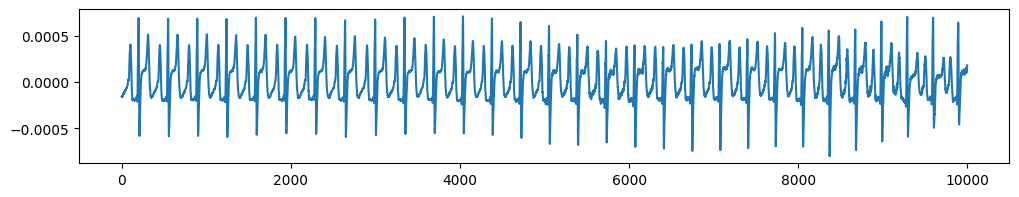

In [481]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(ecg_data[:10000])

In [482]:
min_heartrate = 20
max_heartrate = 150

In [483]:
rpeaks = detect_heartbeats(ecg_data, fs) # using sleepecg
heartrate = np.diff(rpeaks) / fs * 60
heartrate[heartrate < min_heartrate] = np.nan
heartrate[heartrate > max_heartrate] = np.nan
rpeaks = rpeaks[1:]

In [484]:
from scipy.signal import medfilt

In [485]:
# median filter heartrate
median_heartrate = medfilt(heartrate, kernel_size=25)
# mask outliers
heartrate[np.abs(heartrate - median_heartrate) > 10] = np.nan

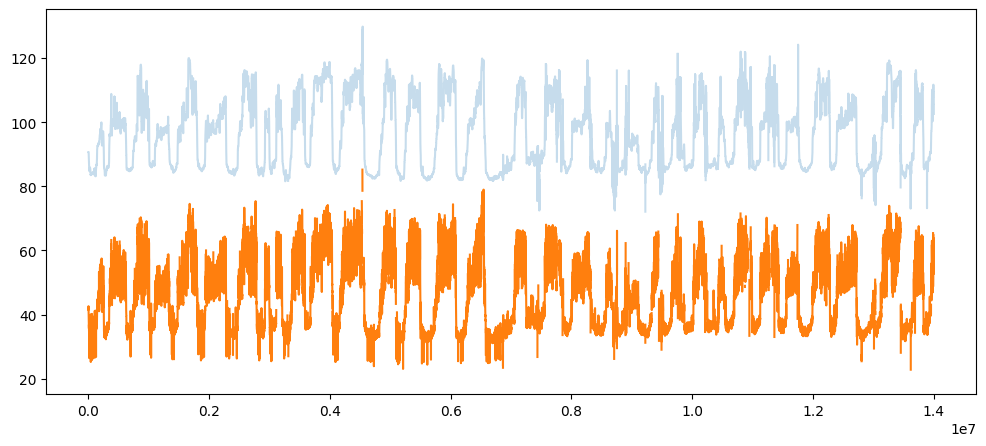

In [486]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rpeaks, median_heartrate+50, alpha = 0.25)
ax.plot(rpeaks, heartrate)

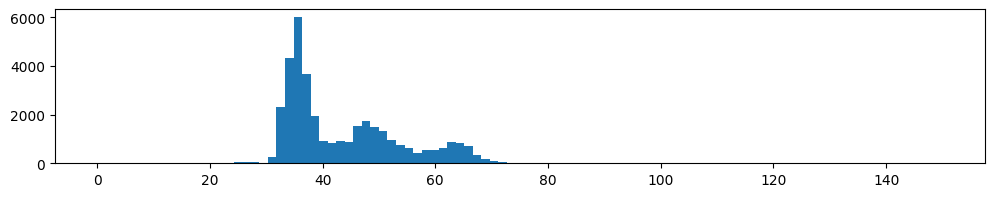

In [487]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.hist(heartrate, bins = np.linspace(0, 150, 100));

In [488]:
len(sleep_codes), len(heartrate), len(heartrate_continuous)

(14000000, 38869, 4000000)

In [489]:
m = np.isnan(heartrate) == False
heartrate = heartrate[m]
rpeaks = rpeaks[m]

In [490]:
# interpolate the heartrate to fill in all points in ecg_data / timepoints
from scipy.interpolate import interp1d
heartrate_continuous = interp1d(rpeaks, heartrate, fill_value='extrapolate')(np.arange(len(ecg_data)))

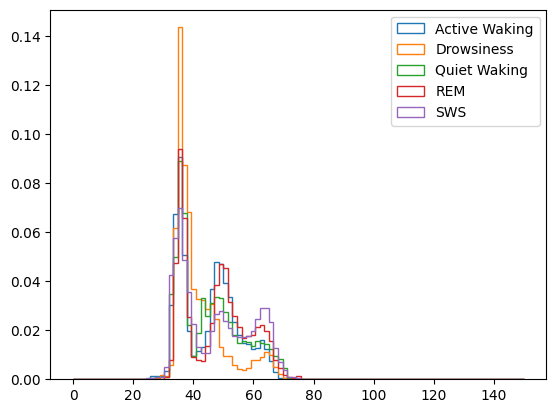

In [491]:
fig, ax = plt.subplots()
for sleep_code in np.unique(sleep_codes):
    hrs = heartrate_continuous[np.array(sleep_codes) == sleep_code]
    ax.hist(hrs,bins = np.linspace(0, 150, 100), histtype='step', label=sleep_code, density=True)
ax.legend()
plt.show()

#### Heartrate variability

In [492]:
from tqdm.auto import tqdm

In [493]:
def calculate_hrv_over_window(ibi_array, window_size):
    # Calculate the differences between successive IBIs
    diff_ibi = np.diff(ibi_array)
    # Square the differences
    squared_diff = diff_ibi ** 2

    # Use a moving window to calculate the sum of squared differences efficiently
    windowed_sum = np.convolve(squared_diff, np.ones(window_size - 1), mode='valid')
    # Divide by the window size to get the mean and then take the square root
    rmssd = np.sqrt(windowed_sum / (window_size - 1))

    # Pad the beginning of the RMSSD array with NaN to match the length of ibi_array
    hrv_values = np.concatenate((np.full(window_size - 1, np.nan), rmssd))

    return hrv_values

In [494]:
def calculate_hrv_over_window(ibi_array, window_size):
    hrv_values = np.full(len(ibi_array), np.nan)  # Initialize HRV values with NaN

    # Iterate over the IBI array, allowing windows to end at the last IBI
    for i in range(len(ibi_array) - window_size + 1):
        # Select the window of IBIs
        window = ibi_array[i:i + window_size]
        # Calculate the differences between successive IBIs within the window
        diff_ibi = np.diff(window)
        # Square the differences
        squared_diff = diff_ibi ** 2
        # Calculate the median of the squared differences and take the square root
        rmssd = np.sqrt(np.median(squared_diff))
        hrv_values[i + window_size - 1] = rmssd  # Assign HRV to the last index of the window

    return hrv_values

In [504]:
n_mins=1
hrv = calculate_hrv_over_window(heartrate, window_size = 120)

In [505]:
len(rpeaks), len(heartrate), len(hrv)

(35925, 35925, 35925)

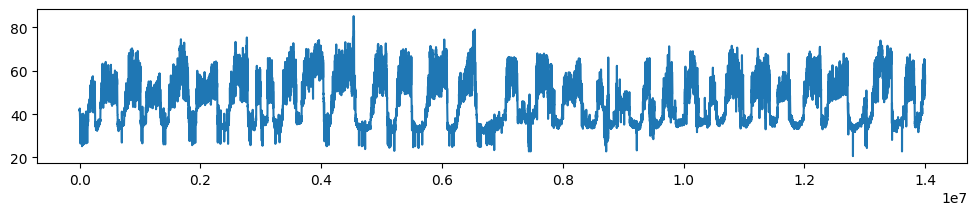

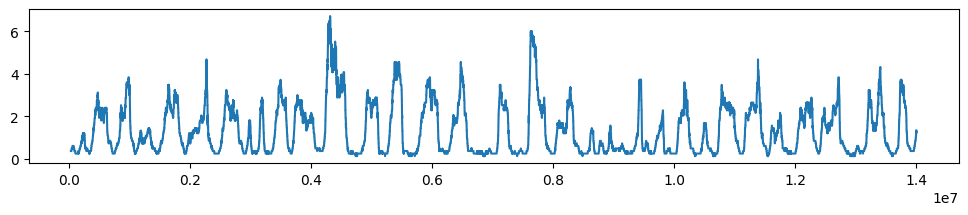

In [506]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(rpeaks, heartrate)

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(rpeaks, hrv)

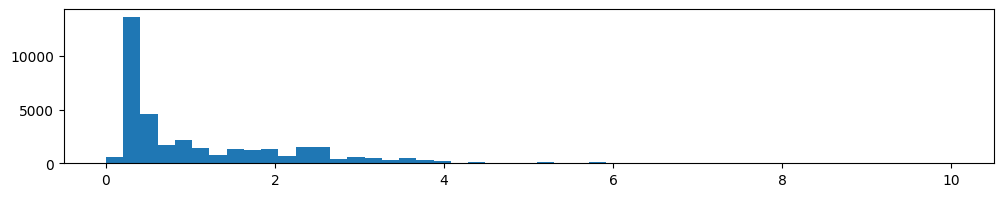

In [507]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.hist(hrv, bins = np.linspace(0, 10, 50));

In [508]:
beat_codes = np.array(sleep_codes)[rpeaks]

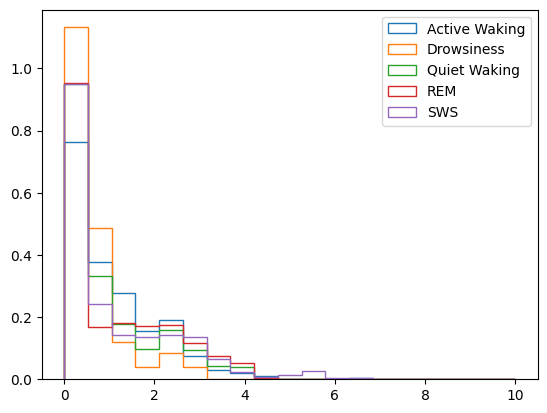

In [511]:
fig, ax = plt.subplots()
for sleep_code in np.unique(beat_codes):
    hrvs = hrv[np.array(beat_codes) == sleep_code]
    ax.hist(hrvs,bins = np.linspace(0, 10, 20), histtype='step', label=sleep_code, density=True)
ax.legend()
plt.show()

In [501]:
# map beat codes to integers
beat_code_dictionary = {code: i for i, code in enumerate(np.unique(beat_codes))}
beat_code_int = np.array([beat_code_dictionary[i] for i in beat_codes])

In [523]:
beat_code_dictionary

{'Active Waking': 0, 'Drowsiness': 1, 'Quiet Waking': 2, 'REM': 3, 'SWS': 4}

In [514]:
beat_code_int

array([2, 2, 2, ..., 4, 4, 4])

In [524]:
from matplotlib.patches import Patch

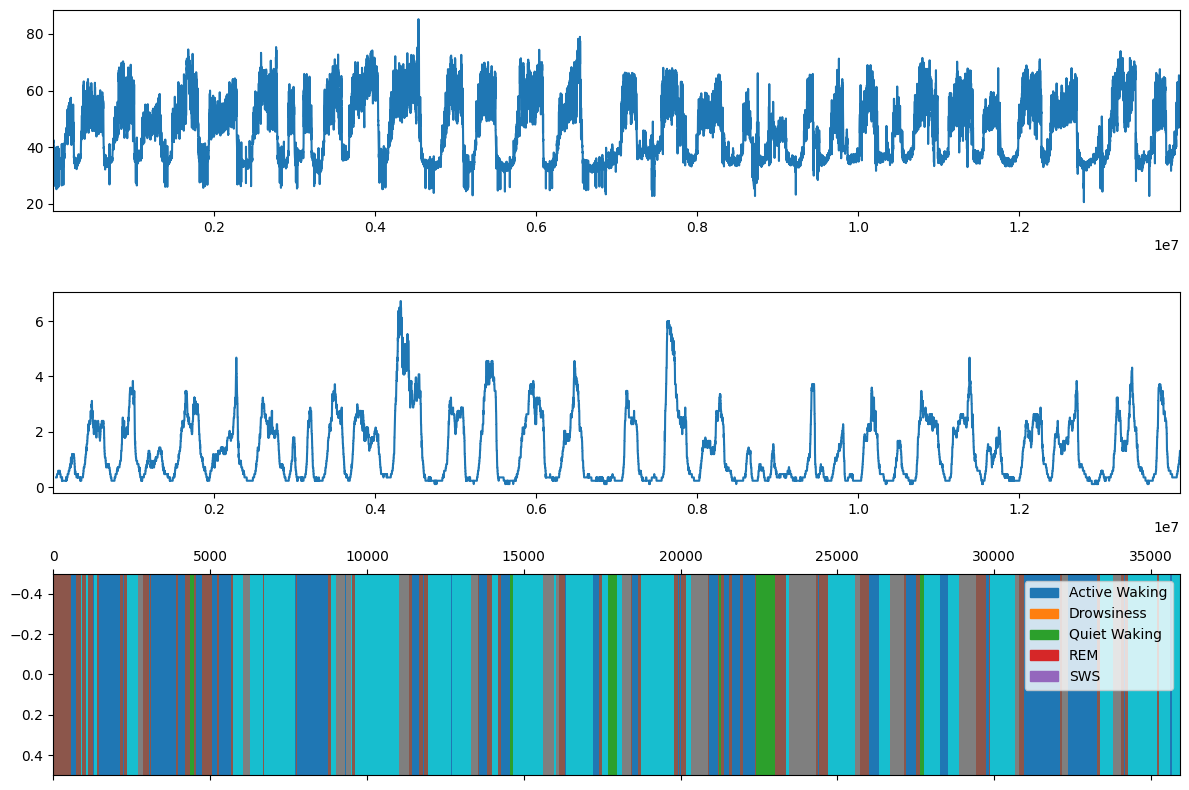

In [525]:
fig, axs = plt.subplots(nrows=3, figsize=(12, 8))
axs[0].plot(rpeaks, heartrate)
axs[0].set_xlim([rpeaks[0], rpeaks[-1]])
axs[1].plot(rpeaks, hrv)
axs[1].set_xlim([rpeaks[0], rpeaks[-1]])
axs[2].matshow(np.expand_dims(beat_code_int, -1).T, aspect='auto', cmap='tab10')


patches = [Patch(color=plt.cm.tab10(beat_code_dictionary[label] / 10), label=label) for label in beat_code_dictionary]
# Add the legend to the plot
axs[2].legend(handles=patches)
plt.tight_layout()

In [529]:
len(beat_code_int), len(rpeaks)

(35925, 35925)

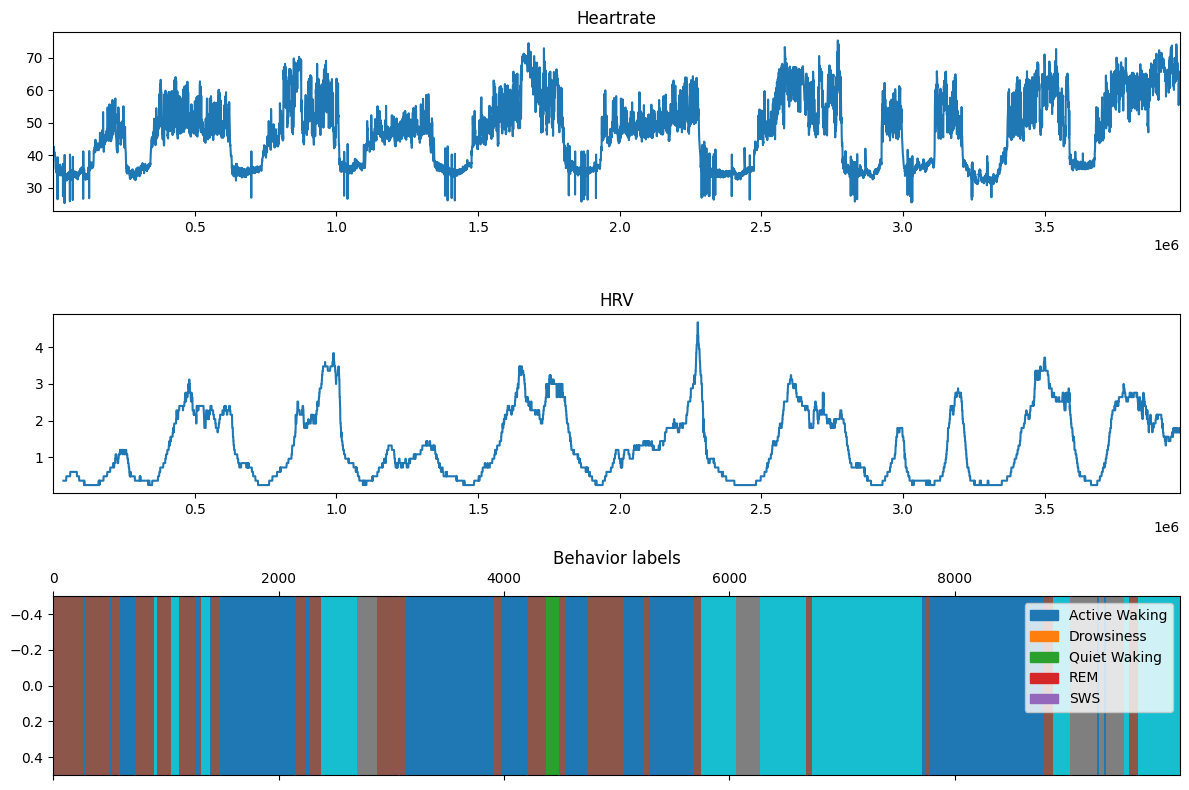

In [531]:
start = 0
end = 10000
fig, axs = plt.subplots(nrows=3, figsize=(12, 8))
axs[0].set_title("Heartrate")
axs[0].plot(rpeaks[start:end], heartrate[start:end])
axs[0].set_xlim([rpeaks[start:end][0], rpeaks[start:end][-1]])
axs[1].plot(rpeaks[start:end], hrv[start:end])
axs[1].set_title("HRV")
axs[1].set_xlim([rpeaks[start:end][0], rpeaks[start:end][-1]])
axs[2].matshow(np.expand_dims(beat_code_int[start:end], -1).T, aspect='auto', cmap='tab10')
axs[2].set_title("Behavior labels")

patches = [Patch(color=plt.cm.tab10(beat_code_dictionary[label] / 10), label=label) for label in beat_code_dictionary]
# Add the legend to the plot
axs[2].legend(handles=patches)
plt.tight_layout()

In [ ]:
beat_code_colors = np.zeros(((len(beat_code_int), 1, 3)))

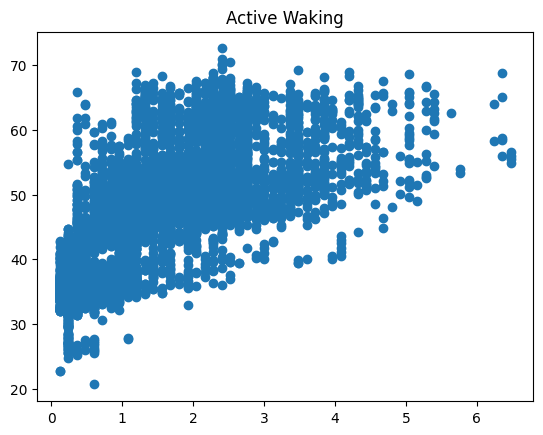

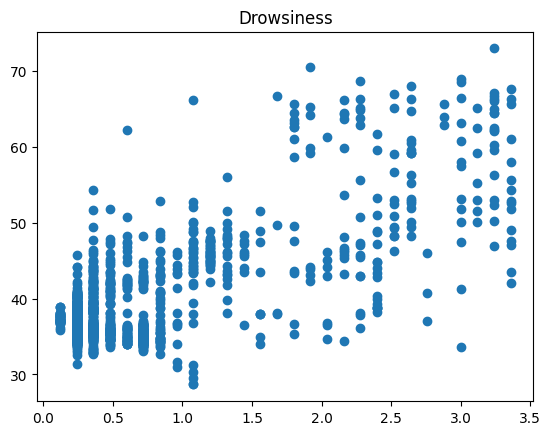

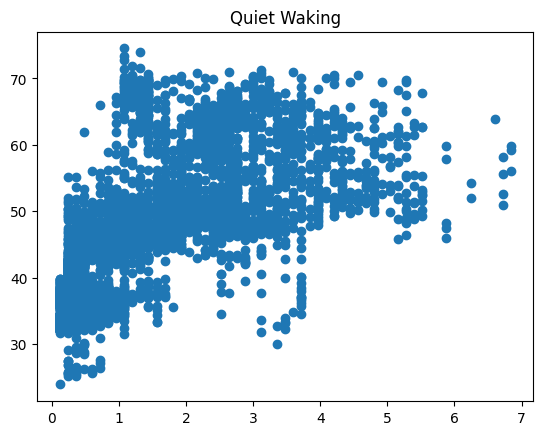

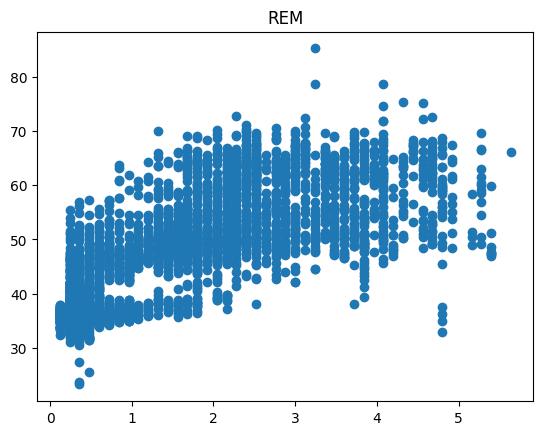

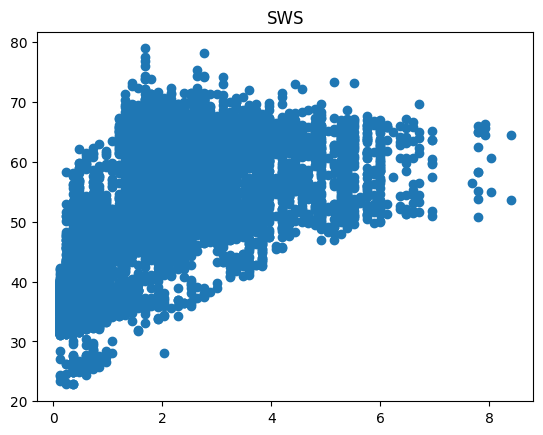

In [502]:
for sleep_code in np.unique(beat_codes):
    m = np.array(beat_codes) == sleep_code
    hrvs = hrv[m]
    heartrates = heartrate[m]
    fig, ax = plt.subplots()
    ax.scatter(hrvs,heartrates, )
    ax.set_title(sleep_code)
    plt.show()

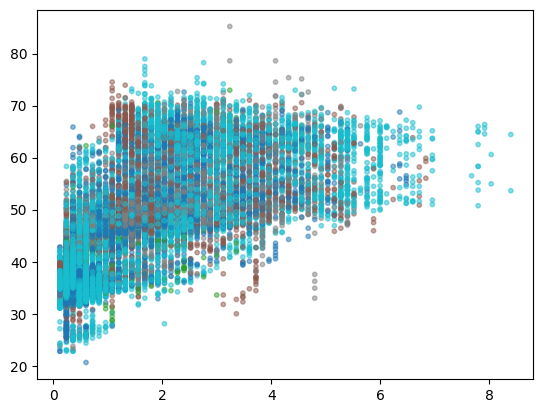

In [503]:
plt.scatter(hrv, heartrate, c = beat_code_int, cmap = 'tab10', alpha = 0.5, s=10)

### EEG features

In [532]:
EEG_channel = "EEG_ICA5"
eeg_data, eeg_timepoint = raw[EEG_channel]
eeg_data.shape, eeg_timepoint.shape, fs

((1, 43200000), (43200000,), 500.0)

In [536]:
### subsample
start_idx = 8000000
stop_idx  = 22000000
eeg_data = eeg_data[0, start_idx:stop_idx]
eeg_timepoint = eeg_timepoint[start_idx:stop_idx]
eeg_data.shape, eeg_timepoint.shape, eeg_timepoint[-1] - eeg_timepoint[0]

((14000000,), (14000000,), 27999.998)

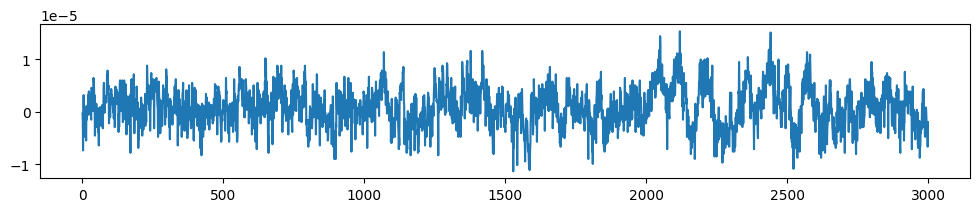

In [539]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(eeg_data[:int(fs*6)])

In [540]:
delta_power = get_rolling_band_power_welch(eeg_data, 0, len(eeg_data), freq_range=(0.5, 4), ref_power=1,
                                                freq=fs, window_sec=30, step_size=1)

In [541]:
delta_power.shape

(28000,)

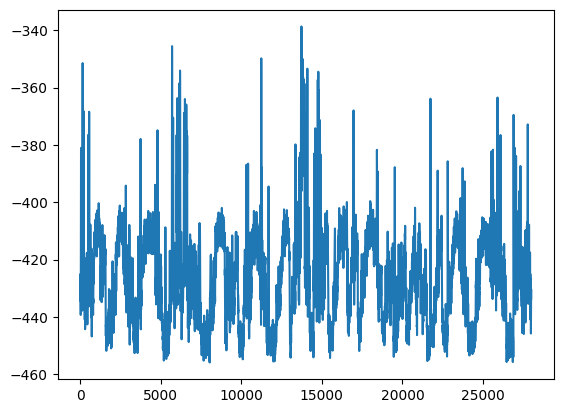

In [542]:
plt.plot(delta_power)

In [543]:
# interpolate the heartrate to fill in all points in eeg
from scipy.interpolate import interp1d
delta_power_continuous = interp1d(np.linspace(0, len(ecg_data), len(delta_power)), delta_power, fill_value='extrapolate')(np.arange(len(ecg_data)))

In [544]:
delta_power_continuous.shape

(14000000,)

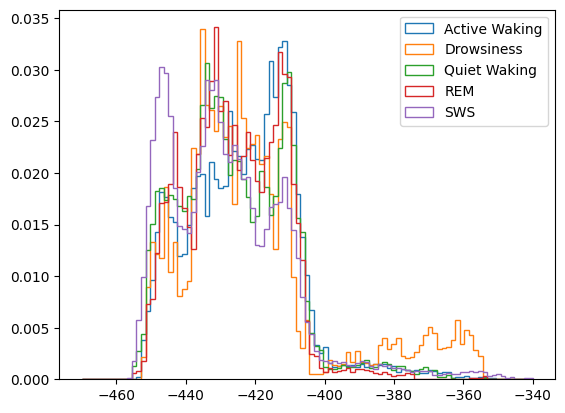

In [549]:
# plot delta power across sleep mode
fig, ax = plt.subplots()
for sleep_code in np.unique(sleep_codes):
    hrs = delta_power_continuous[np.array(sleep_codes) == sleep_code]
    ax.hist(hrs,bins = np.linspace(-470, -340, 100), histtype='step', label=sleep_code, density=True)
ax.legend()
plt.show()

### other frequency bands

In [691]:
FREQ_BANDS = {
    "delta": (0.4, 4.0),
    "theta": (4.0, 8.5),
    "alpha": (8.5, 11.5),
    "sigma": (11.5, 15.5),
    "beta": (15.5, 30)
}
freq_band_names = list(FREQ_BANDS.keys())
freq_band_powers = {}
for freq_band in FREQ_BANDS.keys():
    print(freq_band)
    band_power = get_rolling_band_power_welch(eeg_data, 0, len(eeg_data), freq_range=FREQ_BANDS[freq_band],
                                              ref_power=1, freq=500, window_sec=120, step_size=15)
    freq_band_powers[freq_band] = band_power

delta
theta
alpha
sigma


In [ ]:
n_points = len(freq_band_powers[list(FREQ_BANDS.keys())[0]])
for i in range(n_points):
    # compute the relative power across bands
    total_power = np.sum([freq_band_powers[freq_band][i] for freq_band in freq_band_names])
    for freq_band in freq_band_names:
        freq_band_powers[freq_band][i] = freq_band_powers[freq_band][i] / total_power

In [ ]:
freq_band_powers_continuous = {}
for freq_band in FREQ_BANDS.keys():
    freq_band_powers_continuous[freq_band] = interp1d(np.linspace(0, len(ecg_data), len(freq_band_powers[freq_band])), freq_band_powers[freq_band], fill_value='extrapolate')(np.arange(len(ecg_data)))

delta


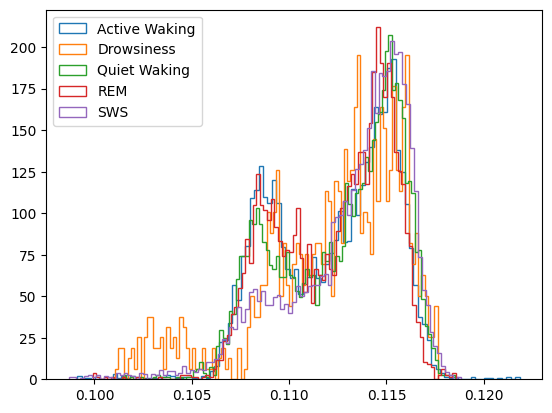

theta


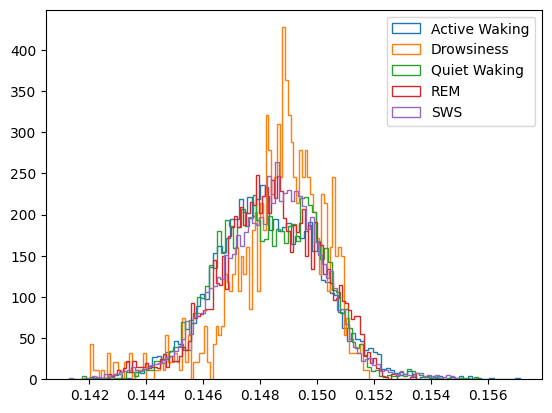

alpha


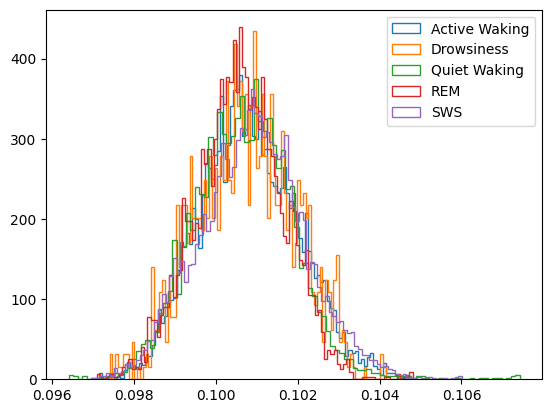

sigma


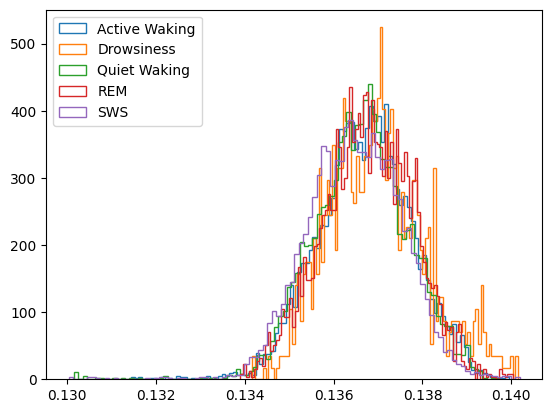

beta


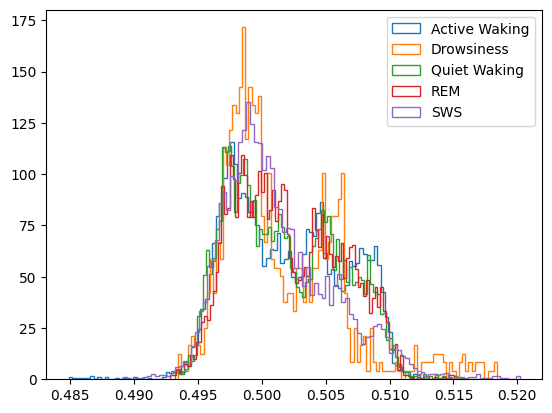

In [ ]:
for band in freq_band_powers.keys():
    print(band)
    times = np.linspace(0, len(ecg_data)-1, len(freq_band_powers[band])).astype(int)
    sleep_codes_bands = np.array(sleep_codes)[times]
    # plot delta power across sleep mode
    fig, ax = plt.subplots()
    for sleep_code in np.unique(sleep_codes):
        m = np.array(sleep_codes_bands) == sleep_code
        hrs = np.array(freq_band_powers[band])[m]
        ax.hist(hrs,bins = 100, histtype='step', label=sleep_code, density=True)
    ax.legend()
    plt.show()

### Get pressure feature

In [ ]:
pressure_channel = "Pressure"
pressure_data, pressure_timepoint = raw[pressure_channel]
pressure_data.shape, pressure_timepoint.shape, fs

((1, 43200000), (43200000,), 500.0)

In [ ]:
### subsample
start_idx = 8000000
stop_idx  = 22000000
pressure_data = pressure_data[0, start_idx:stop_idx]
pressure_timepoint = pressure_timepoint[start_idx:stop_idx]
pressure_data.shape, pressure_timepoint.shape, pressure_timepoint[-1] - pressure_timepoint[0]

((14000000,), (14000000,), 27999.998)

In [577]:
median_pressure_data = medfilt(pressure_data, kernel_size=501)

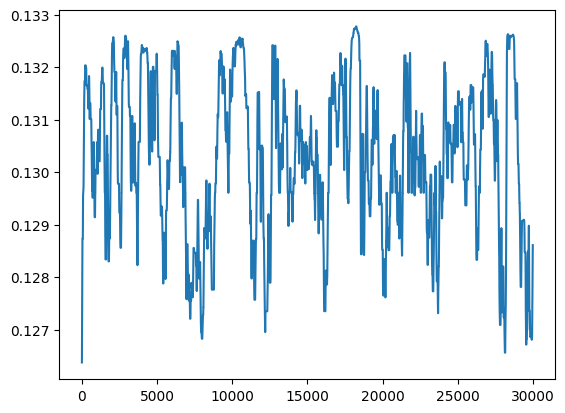

In [578]:
plt.plot(median_pressure_data[:int(fs*60)])

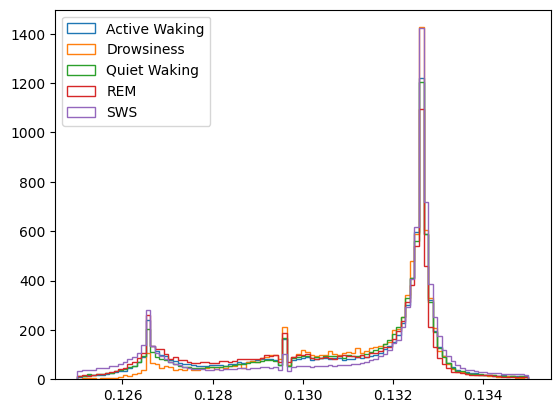

In [581]:
# plot delta power across sleep mode
fig, ax = plt.subplots()
for sleep_code in np.unique(sleep_codes):
    hrs = median_pressure_data[np.array(sleep_codes) == sleep_code]
    ax.hist(hrs,bins = np.linspace(0.125, 0.135, 100), histtype='step', label=sleep_code, density=True)
ax.legend()
plt.show()

### UMAP plot

In [572]:
from umap import UMAP

In [658]:
len(heartrate), len(hrv), len(rpeaks)

(35925, 35925, 35925)

In [659]:
dataframe = pd.DataFrame(np.array([heartrate, hrv, median_pressure_data[rpeaks]]).T, columns = ['heartrate', 'hrv', 'pressure'])
for freq_band in FREQ_BANDS.keys():
    dataframe[freq_band] = freq_band_powers_continuous[freq_band][rpeaks]

In [660]:
len(dataframe)

35925

In [661]:
dataframe[:3]

,heartrate,hrv,pressure,delta,theta,alpha,sigma,beta
0,41.88,NaN,0.131316,NaN,NaN,NaN,NaN,NaN
1,41.40,NaN,0.129609,NaN,NaN,NaN,NaN,NaN
2,41.52,NaN,0.131206,NaN,NaN,NaN,NaN,NaN


In [662]:
m = dataframe.isnull().sum(axis=1) == 0

In [663]:
dataframe = dataframe[m]

In [664]:
len(dataframe)

35791

In [665]:
dataframe

,heartrate,hrv,pressure,delta,theta,alpha,sigma,beta
119,33.96,0.36,0.128234,-394.263658,-502.748150,-341.717271,-477.052988,-1805.238983
120,33.84,0.36,0.128728,-393.166992,-500.850563,-340.478939,-475.908184,-1803.006014
121,32.52,0.36,0.129686,-392.145233,-499.209299,-339.412633,-474.842266,-1801.085760
122,33.60,0.36,0.131206,-391.858669,-498.473144,-338.950217,-474.720534,-1802.029665
123,32.28,0.36,0.131493,-391.708669,-497.954527,-338.631234,-474.673251,-1803.383421
...,...,...,...,...,...,...,...,...
35905,64.68,0.96,0.122909,-443.519297,-583.812061,-396.394125,-535.827551,-1970.835411
35906,59.40,0.96,0.123963,-442.197855,-582.836335,-396.719826,-535.458643,-1969.215970
35907,55.44,1.08,0.123512,-441.747110,-581.651895,-397.619883,-534.963765,-1969.854219
35908,57.72,1.08,0.126291,-441.782567,-581.002366,-398.649995,-534.237352,-1970.656330


In [666]:
def zscore(x):
    return (x - np.mean(x))/np.std(x)

In [667]:
for column in dataframe.columns:
    dataframe[column] = zscore(dataframe[column].values)

In [668]:
x = dataframe.values

In [669]:
x.shape

(35791, 8)

In [632]:
z = UMAP(verbose=True).fit_transform(x)

UMAP( verbose=True)
Fri Mar 29 13:03:01 2024 Construct fuzzy simplicial set
Fri Mar 29 13:03:01 2024 Finding Nearest Neighbors
Fri Mar 29 13:03:01 2024 Building RP forest with 14 trees
Fri Mar 29 13:03:03 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Mar 29 13:03:10 2024 Finished Nearest Neighbor Search
Fri Mar 29 13:03:11 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Mar 29 13:03:21 2024 Finished embedding


In [670]:
# map beat codes to integers
beat_code_dictionary = {code: i for i, code in enumerate(np.unique(beat_codes))}
beat_code_int = np.array([beat_code_dictionary[i] for i in beat_codes])

In [671]:
# create a dictionary of beat_code_dictionary keys to a tab10 color
beat_code_color_dict = {code: plt.cm.tab10(beat_code_dictionary[code] / 10) for code in beat_code_dictionary}

In [672]:
beat_code_color_dict

{'Active Waking': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'Drowsiness': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'Quiet Waking': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 'REM': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 'SWS': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)}

In [673]:
beat_code_colors = np.array([beat_code_color_dict[i] for i in beat_codes])

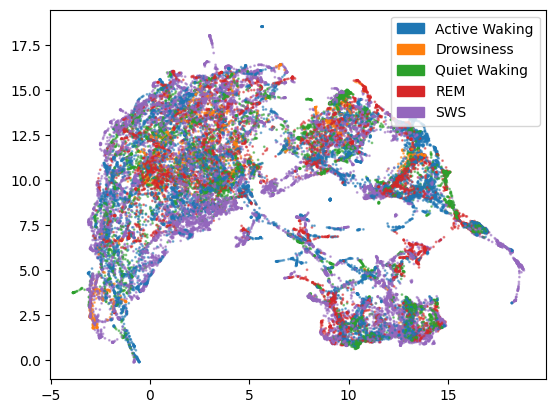

In [677]:
fig, ax = plt.subplots()
ax.scatter(z[:,0], z[:,1], c = beat_code_colors[m],  alpha = 0.5, s=1)
# add a legend with the beat_code_dictionary keys
patches = [Patch(color=beat_code_color_dict[label], label=label) for label in beat_code_dictionary]
# Add the legend to the plot
ax.legend(handles=patches)

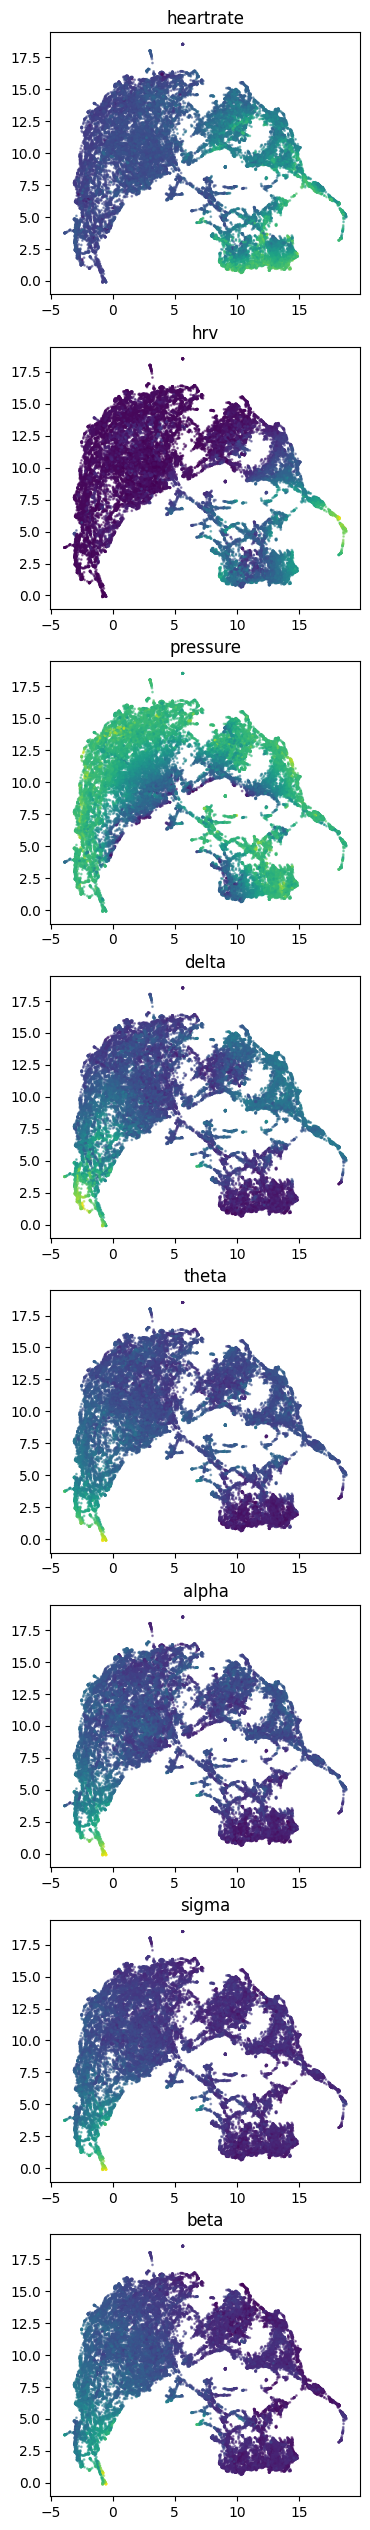

In [680]:
# plot the umap colored by features in viridis
fig, axs = plt.subplots(nrows=len(dataframe.columns), figsize=(4, len(dataframe.columns)*4))
for i, column in enumerate(dataframe.columns):
    axs[i].scatter(z[:,0], z[:,1], c = dataframe[column][m], cmap = 'viridis', alpha = 0.5, s=1)
    axs[i].set_title(column)